# Playground - RSA (Respiratory sinus arrhythmia)
Very helpful - official repo of the physio library (processing ECG and Respiratory signals) - https://github.com/samuelgarcia/physio_benchmark/tree/main

Dataset is Zenodo

In [2]:
import os
import numpy as np
import tqdm
import neurokit2 as nk
import matplotlib.pyplot as plt
import torch
from models.models import LSTM
from customLib.vis import plot_ecg
from customLib.preprocess import myConv1D
from customLib.preprocess import dwt_denoise
from customLib.preprocess import resample_signal
from customLib.preprocess import norm_min_max
from customLib.preprocess import split_signal
from customLib.dataset import label_ecgs
from customLib.peak_detection import group_peaks, find_mean_avg_r_peak_indices


In [2]:
path = "E:\\ml-data\\masters-thesis\\RSA\\Zenodo\\human"

In [3]:
sample_data = np.loadtxt(path +"\\S00.txt")
sample_data.shape
raw_ecg = sample_data[:, 0]
raw_resp = sample_data[:, 1]

srate = 1000
times = np.arange(raw_ecg.size) / srate

[]

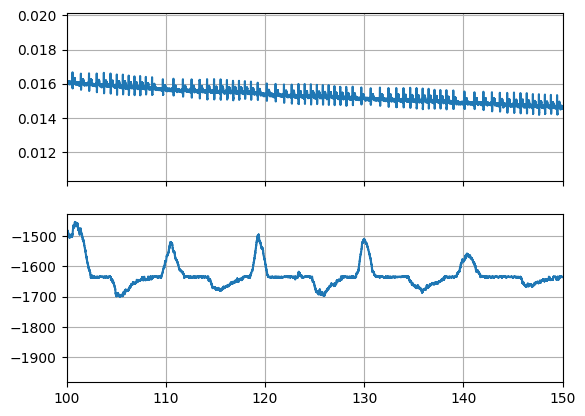

In [5]:
fig, axs = plt.subplots(sharex=True, nrows=2)
ax = axs[0]
ax.plot(times, raw_ecg)
ax.grid()

ax = axs[1]
ax.plot(times, raw_resp)
ax.grid()

ax.set_xlim(100, 150)
plt.plot()


'\nax = axs[0][1]\nax.set_title("Wygładzony i odszumiony sygnał")\nax.plot(times[:10000], smoothened_denoised)\nax.grid()\n\n\nax = axs[1][1]\nax.set_title("Wygładzony,odszumiony i decymowany sygnał")\nax.plot(time_resampled, smoothened_denoised_downsampled)\nax.grid()\n\nfig.set_size_inches(10, 6)\nplt.plot()\n'

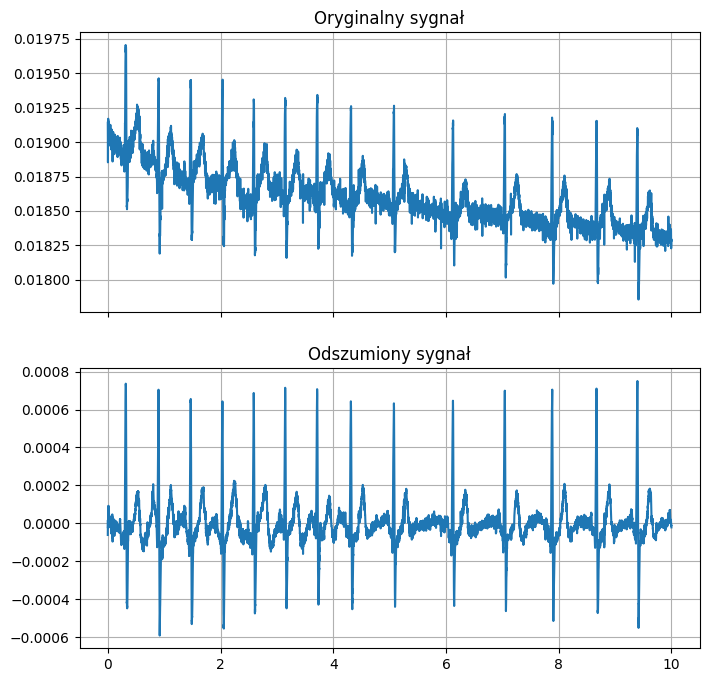

In [25]:
ecg_sample = raw_ecg[:10000]
normalized_ecg = norm_min_max(ecg_sample, -1, 1)
smoothened_ecg = myConv1D(signal=normalized_ecg, kernel_length=5, padding="same")
denoised_ecg = dwt_denoise(signal=ecg_sample)
smoothened_denoised = myConv1D(signal=denoised_ecg, kernel_length=5, padding="same")
smoothened_denoised_downsampled = resample_signal(smoothened_denoised, 1000)
time_resampled = times[:10000:10]

#fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True)
fig, axs = plt.subplots(nrows=2, sharex=True)
ax = axs[0]
ax.set_title("Oryginalny sygnał")
ax.plot(times[:10000], ecg_sample)
ax.grid()

ax = axs[1]
ax.set_title("Odszumiony sygnał")
ax.plot(times[:10000], denoised_ecg)
ax.grid()

fig.set_size_inches(8, 8)

"""
ax = axs[0][1]
ax.set_title("Wygładzony i odszumiony sygnał")
ax.plot(times[:10000], smoothened_denoised)
ax.grid()


ax = axs[1][1]
ax.set_title("Wygładzony,odszumiony i decymowany sygnał")
ax.plot(time_resampled, smoothened_denoised_downsampled)
ax.grid()

fig.set_size_inches(10, 6)
plt.plot()
"""

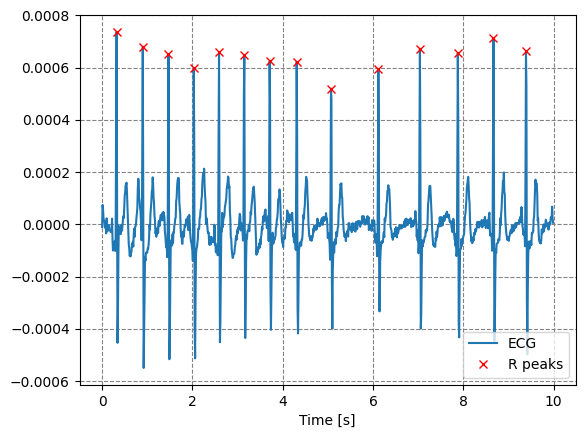

In [6]:
_, r_peaks = nk.ecg_peaks(ecg_cleaned=smoothened_denoised_downsampled, sampling_rate=100)
r_peaks = r_peaks["ECG_R_Peaks"]
plot_ecg(smoothened_denoised_downsampled, r_peaks, 100)

### Test pretrained LSTM for R-peak detection

In [3]:
model = LSTM(input_dim=1, hidden_size=32, lr=1e-4, loss_pos_weight=torch.Tensor(1))
model.load_state_dict(torch.load("./checkpoints/lstm/lstm_epoch_50_acc_99.80_f1_0.97.pt"))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def predict(model, x):
    assert len(x.shape) == 3

    x_tensor = torch.from_numpy(x)
    x_tensor = x_tensor.to(device)
    x_tensor = x_tensor.float()

    sigmoid = torch.nn.Sigmoid()

    prediction = model.forward(x_tensor)
    prediction = prediction.cpu().detach()
    prediction = sigmoid(prediction)
    prediction = prediction.numpy()

    r_peaks_corrected = []

    for example in prediction:
        r_peaks = np.where(example.flatten() > 0.5, 1, 0)
        r_peaks = find_mean_avg_r_peak_indices(r_peaks)
        r_peaks_corrected.append(r_peaks)

    r_peaks_corrected = np.array(r_peaks_corrected)

    return r_peaks_corrected

Training will be performed with: cuda:0


e:\anaconda3\envs\torch\Lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\patry\AppData\Local\Temp\ipykernel_8400\4023313703.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `tor

In [8]:
smoothened_ecg = myConv1D(raw_ecg, 5, "same")
resampled_ecg = smoothened_ecg[::10]
ecgs = split_signal(signal=resampled_ecg, window_in_seconds=10, fs=100, normalize=True, denoise=True)
x = np.array(ecgs)
y = label_ecgs(ecgs=x, sampling_rate=100)

Total ECGs: 33


100%|██████████| 33/33 [00:00<00:00, 646.59it/s]


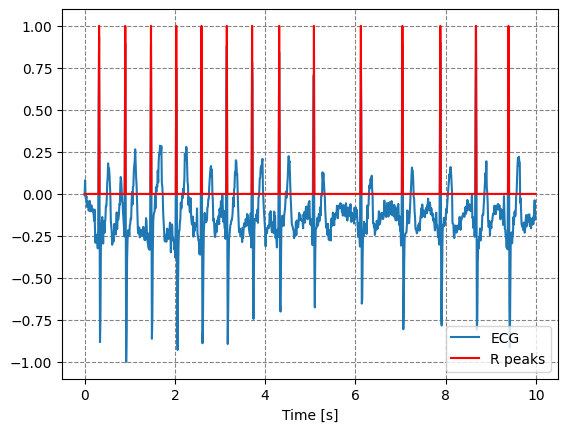

In [9]:
plot_ecg(x[0].flatten(), y[0], 100)

In [10]:
x = np.expand_dims(x, axis=2)
y = np.expand_dims(y, axis=2)
print("X: ", x.shape)
print("Y: ", y.shape)

X:  (33, 1000, 1)
Y:  (33, 1000, 1)


In [11]:
r_peaks = predict(model, x)

In [4]:
def peaks_to_rri(r_peaks: np.ndarray, sampling_rate=100):
  if np.max(r_peaks) > 1: # passed as indices vector
    indices = r_peaks
  else:
    indices = np.where(r_peaks == 1)[0]

  indices_seconds = indices * 1 / sampling_rate * 1000

  rri = np.diff(indices_seconds)
  return rri

C:\Users\patry\AppData\Local\Temp\ipykernel_5996\1196529311.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(ncols=2)


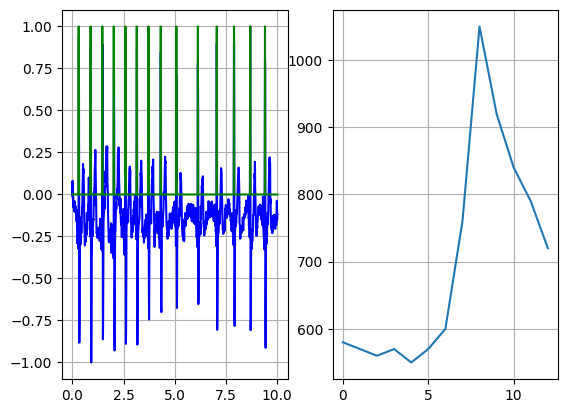

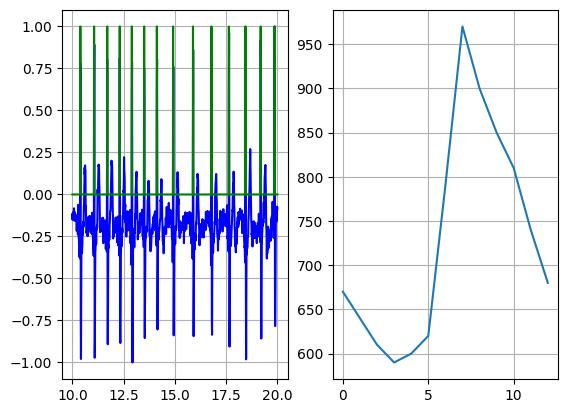

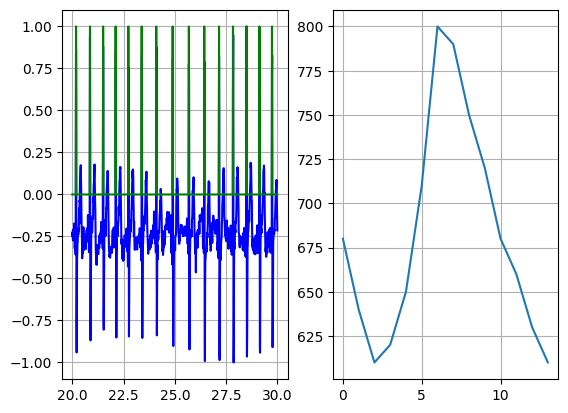

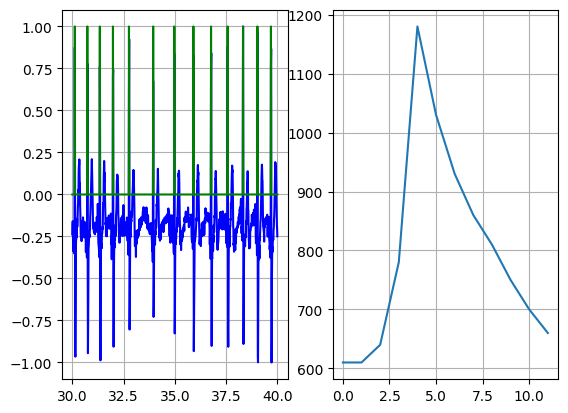

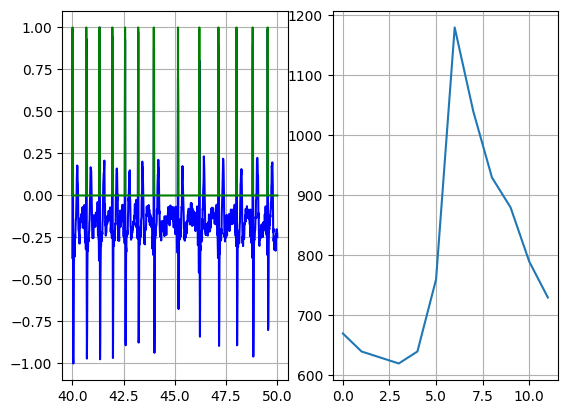

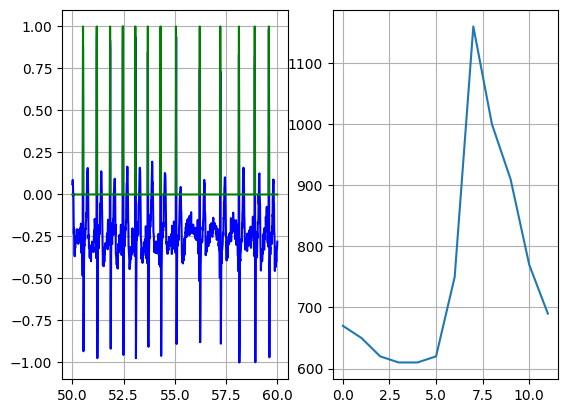

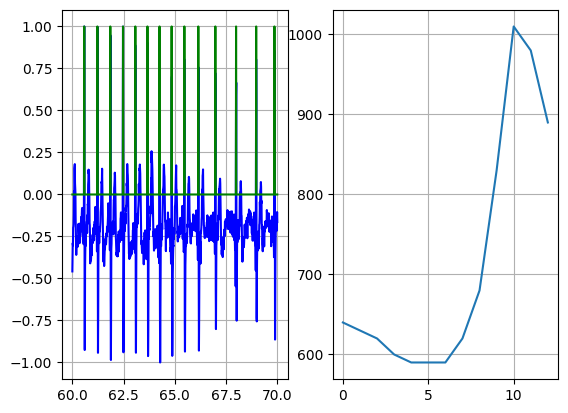

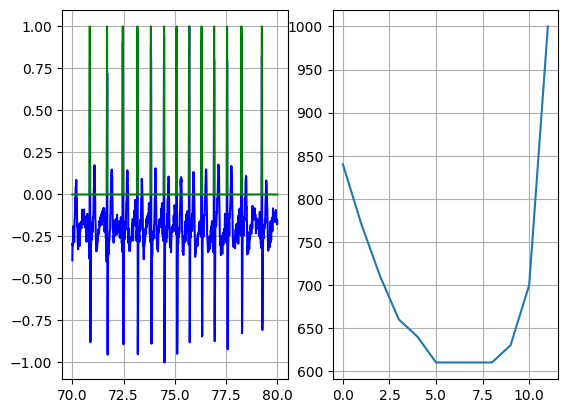

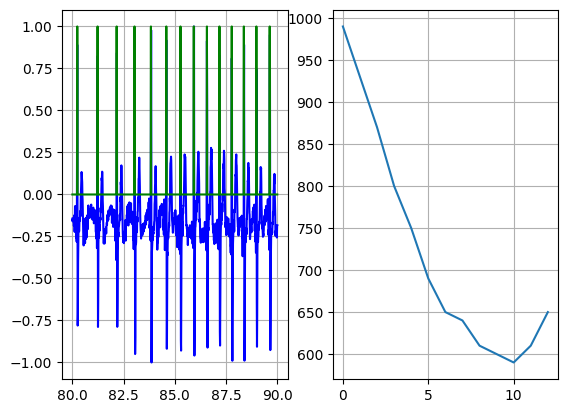

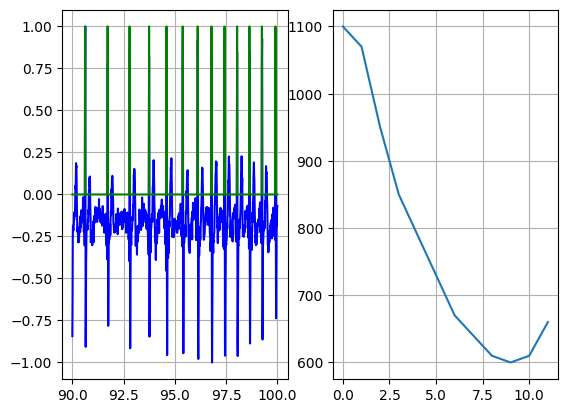

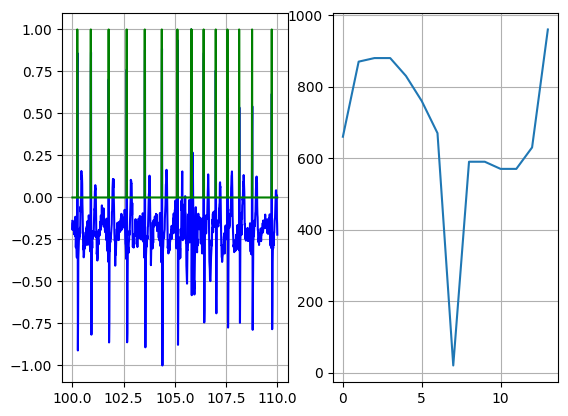

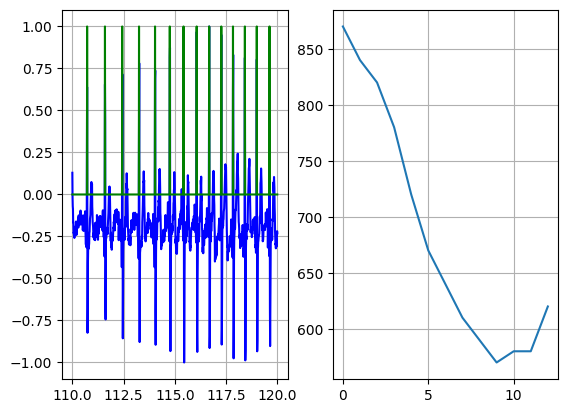

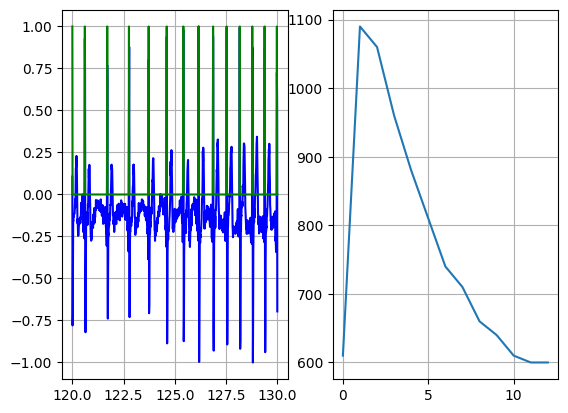

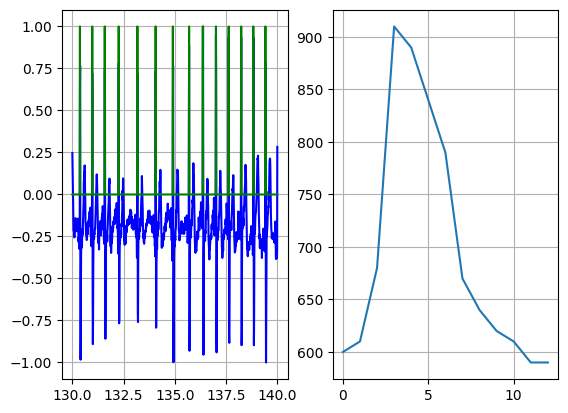

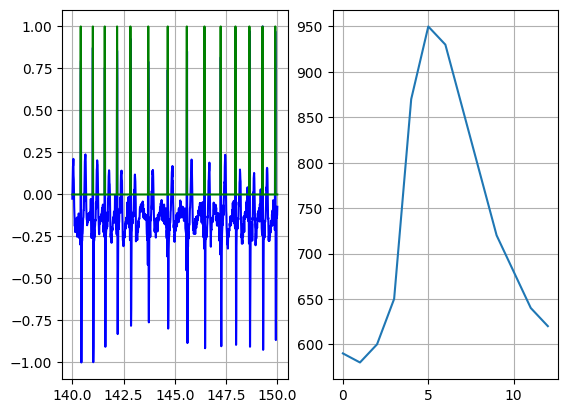

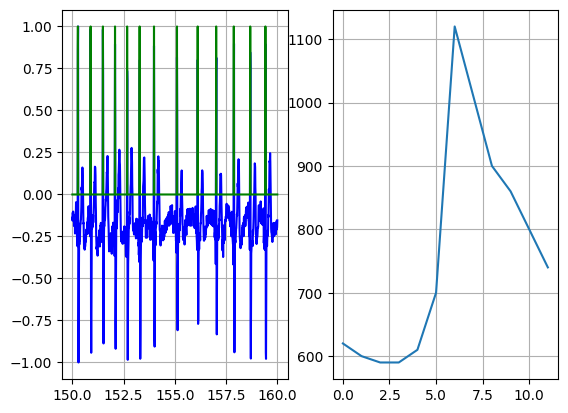

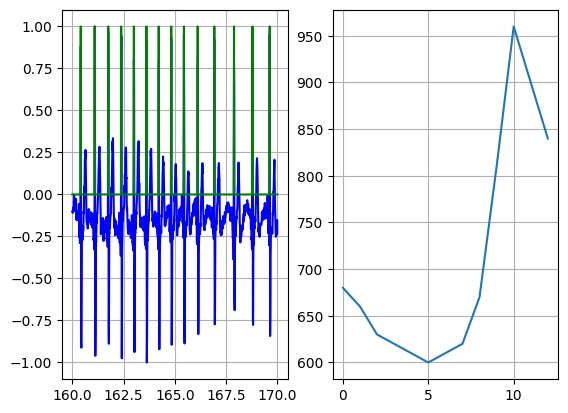

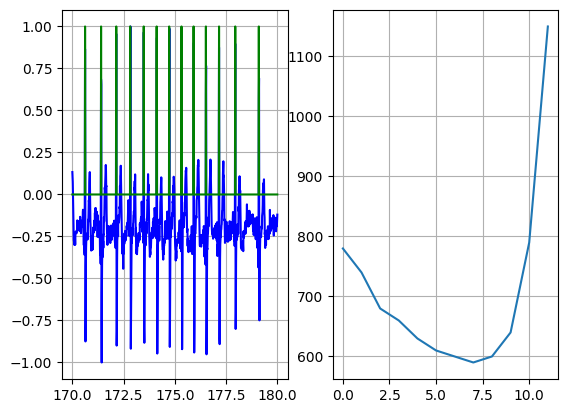

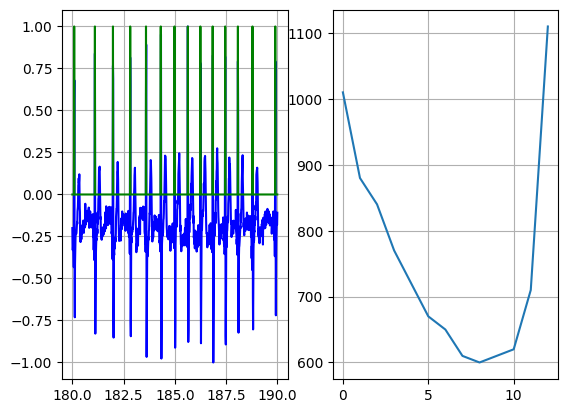

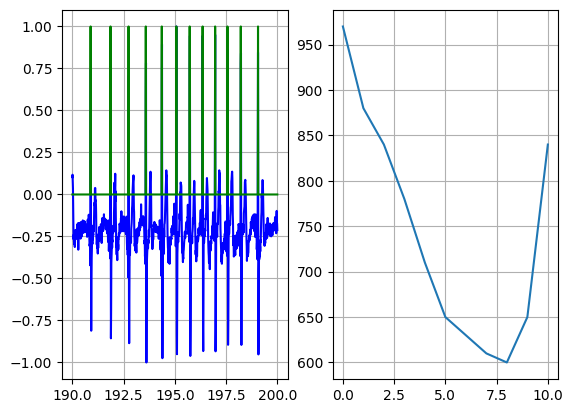

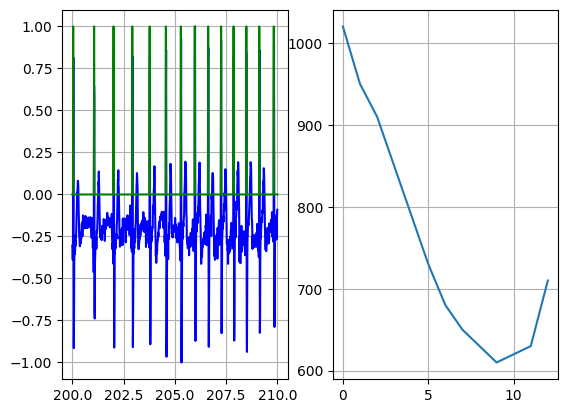

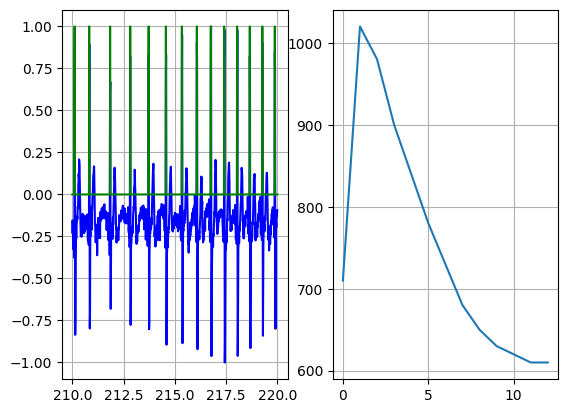

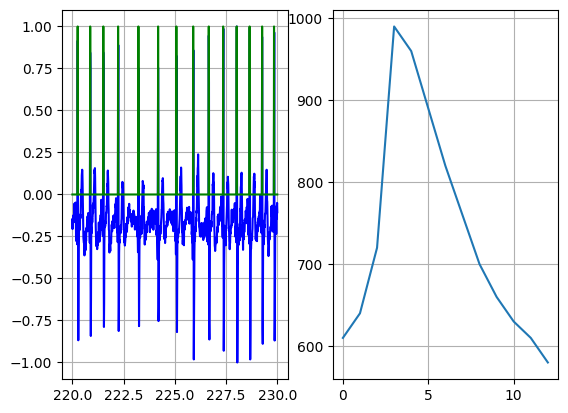

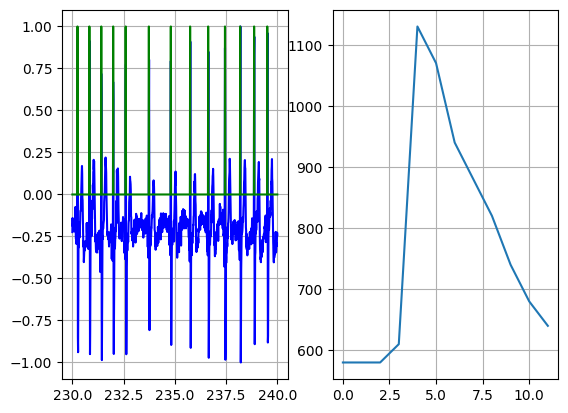

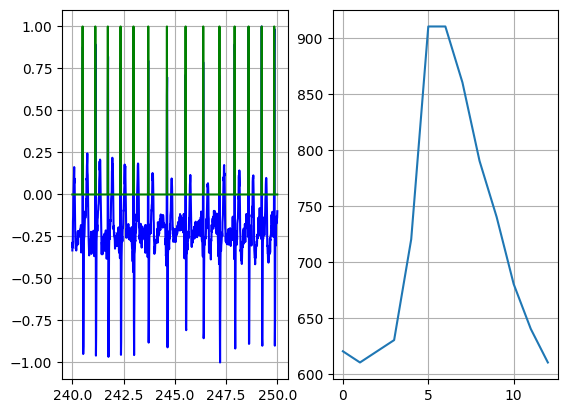

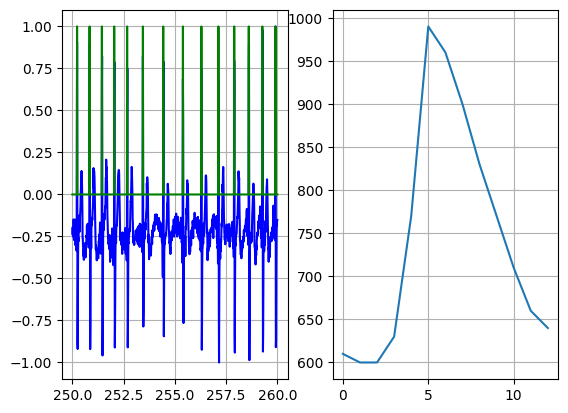

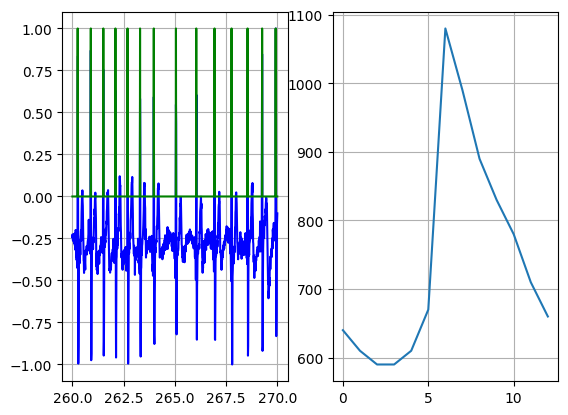

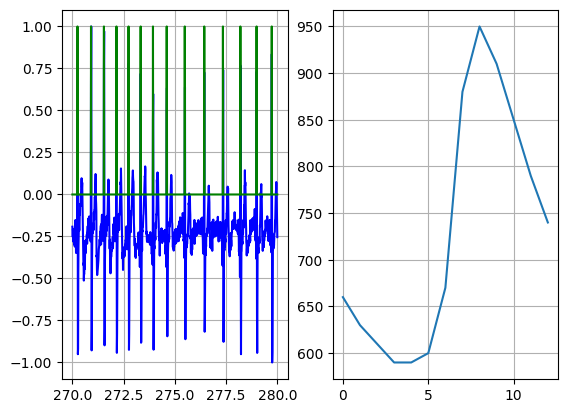

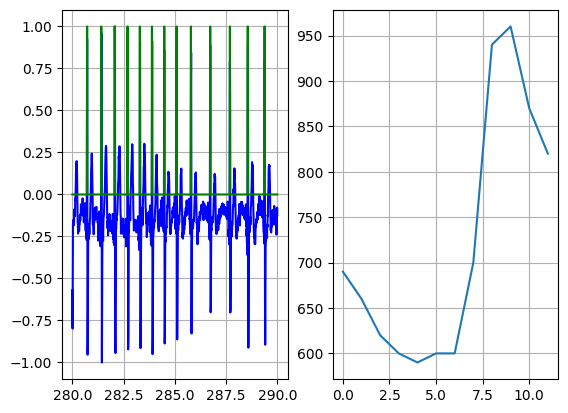

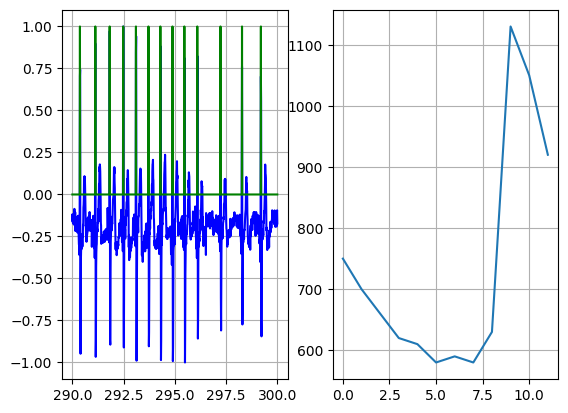

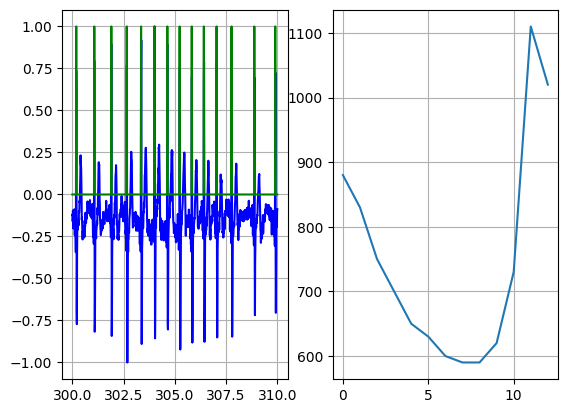

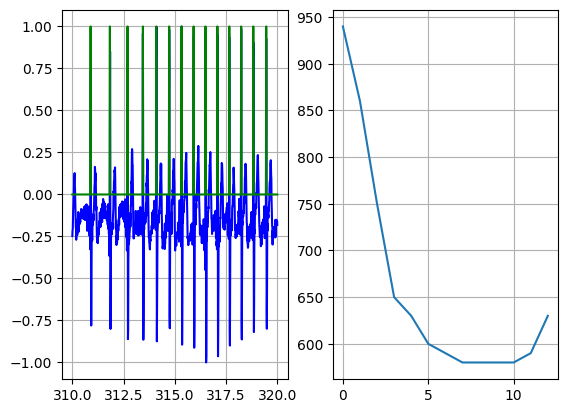

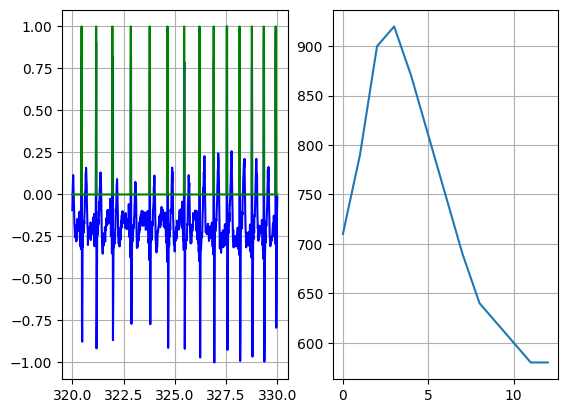

In [13]:
whole = None

t = np.linspace(start=0, stop=10, num=1000)
whole = []

all_indices = None

for i in range(x.shape[0]):
  ecg = x[i].flatten()
  gt = y[i].flatten()
  r = r_peaks[i].flatten()
  indices = np.where(r > 0.5)[0]

  if all_indices is None:
    all_indices = np.array(indices)
  else:
    all_indices = np.concatenate((all_indices, indices + i * 1000))

  error = np.zeros_like(ecg)
  error_indices = np.where(r != gt)[0]

  fig, axs = plt.subplots(ncols=2)
  ax = axs[0]
  ax.plot(t, ecg, "b-")
  ax.plot(t, r, "g-")
  #for error in error_indices:
  # ax.vlines(x=t[error_indices], ymin=0, ymax=1, colors="r", linestyles="--")
  ax.grid()

  rris = peaks_to_rri(r)

  ax = axs[1]
  ax.plot(rris)
  ax.grid()

  t += 10


In [14]:
all_r_peaks = np.zeros_like(raw_ecg)
all_r_peaks[all_indices] = 1
whole_ecg = x.flatten()

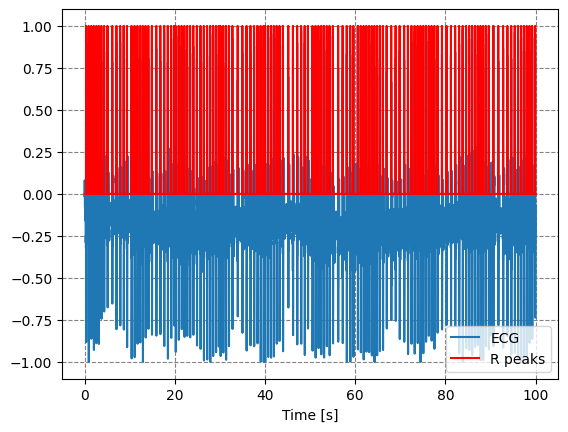

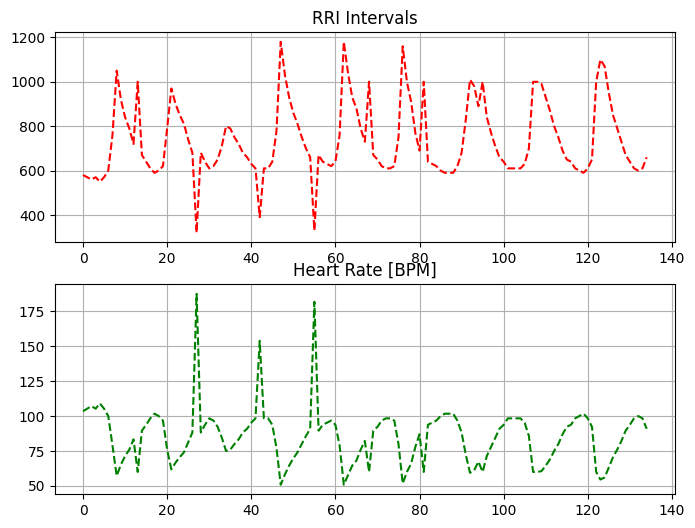

In [15]:
length = 10000

ecg = whole_ecg[:length]
r_peaks = all_r_peaks[:length]
plot_ecg(ecg, r_peaks, 100)

rri_indices = [x for x in range(len(peaks_to_rri(all_r_peaks[:length])))]
rris = peaks_to_rri(all_r_peaks[:length])

fig, axs = plt.subplots(nrows=2)
ax = axs[0]
ax.grid()
ax.plot(rri_indices, rris, "r--")
ax.set_title("RRI Intervals")

bpm = 60 / rris * 1000

ax = axs[1]
ax.grid()
ax.plot(rri_indices, bpm, "g--")
ax.set_title("Heart Rate [BPM]")

fig.set_size_inches(h=6, w=8)

## Respiratory data from the Apnea-ecg dataset

In [16]:
import os
import wfdb
from customLib.config import apnea_ecg_path

files = [x for x in os.listdir(apnea_ecg_path) if x.endswith("r.dat")]
print(files)

['a01r.dat', 'a02r.dat', 'a03r.dat', 'a04r.dat', 'b01r.dat', 'c01r.dat', 'c02r.dat', 'c03r.dat']


In [17]:
respiratory_data = wfdb.rdrecord(apnea_ecg_path + "\\a01r")
respiratory_ann = wfdb.rdann(apnea_ecg_path + "\\a01r", extension="apn")

ecg_data = wfdb.rdrecord(apnea_ecg_path + "\\a01")

In [18]:
print(respiratory_data.sig_name)
print("Respiratory sampling rate: ",  respiratory_data.fs)
print("ECG channels: ", ecg_data.n_sig)
print("ECG sampling rate: ", ecg_data.fs)
# Resp C - chest
# Resp A - abdominal
# Resp N - nasal
# SpO2 - oxygen saturation

['Resp C', 'Resp A', 'Resp N', 'SpO2']
Respiratory sampling rate:  100
ECG channels:  1
ECG sampling rate:  100


In [19]:
resp_n = respiratory_data.p_signal[:5000,2].flatten()
ecg = ecg_data.p_signal[:5000].flatten()

In [20]:
ecg = np.reshape(ecg, (1, len(ecg), 1))

r_peaks = predict(model=model, x=ecg)

In [21]:
r_peaks = find_mean_avg_r_peak_indices(r_peaks)
rris_ms = peaks_to_rri(r_peaks)
rris_s = rris_ms / 1000

dt = 1/100

first_order_dx = (rris_s[1:] - rris_s[:-1]) / dt
second_order_dx = (rris_s[2:] - 2*rris_s[1:-1] + rris_s[:-2]) / (dt**2)

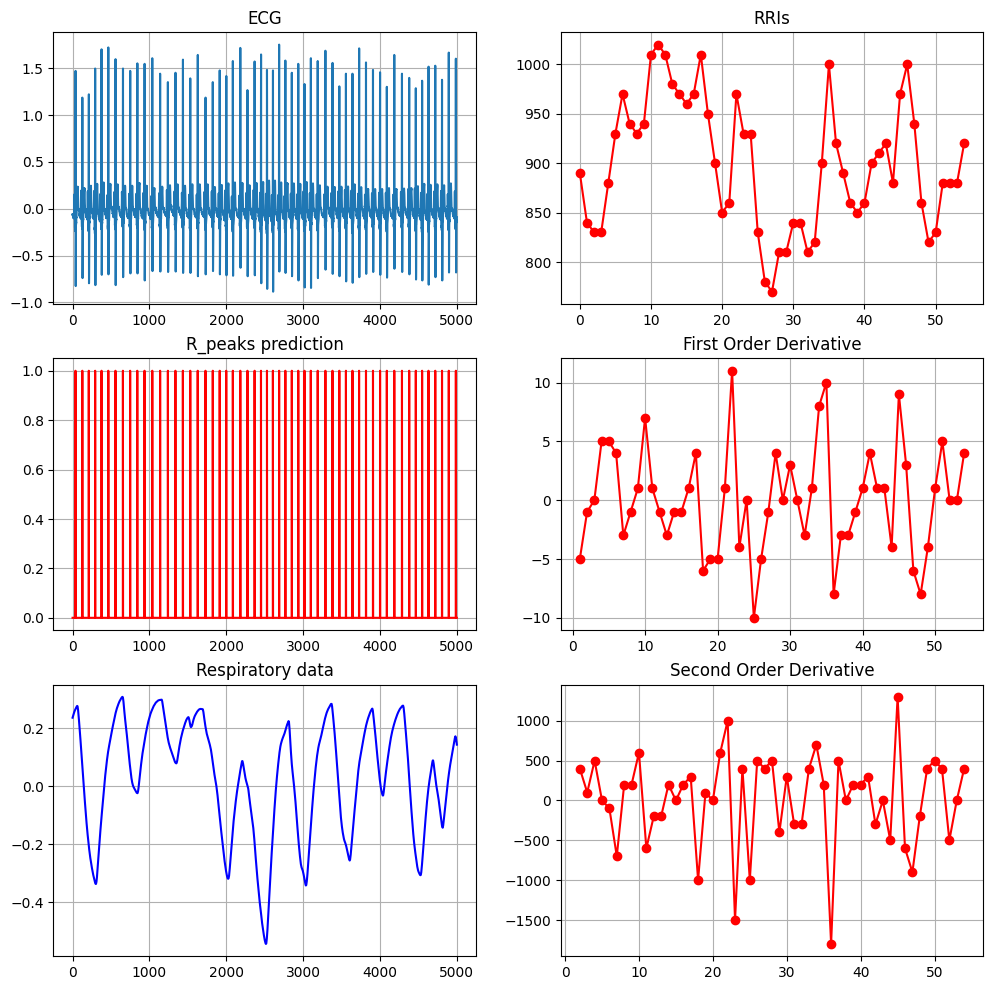

In [23]:
fig, axs = plt.subplots(nrows=3, ncols=2)

ax = axs[0][0]
ax.plot(ecg.flatten())
ax.grid()
ax.set_title("ECG")


ax = axs[1][0]
ax.plot(r_peaks, "r-")
ax.grid()
ax.set_title("R_peaks prediction")

ax = axs[2][0]
ax.plot(resp_n, "b-")
ax.grid()
ax.set_title("Respiratory data")

ax = axs[0][1]
ax.plot(rris_ms, "r-o")
ax.grid()
ax.set_title("RRIs")

ax = axs[1][1]
ax.plot([x for x in range(1, len(rris_s))], first_order_dx, "r-o")
ax.grid()
ax.set_title("First Order Derivative")

ax = axs[2][1]
ax.plot([x for x in range(2, len(rris_s))], second_order_dx, "r-o")
ax.grid()
ax.set_title("Second Order Derivative")

fig.set_size_inches(h=12, w=12)

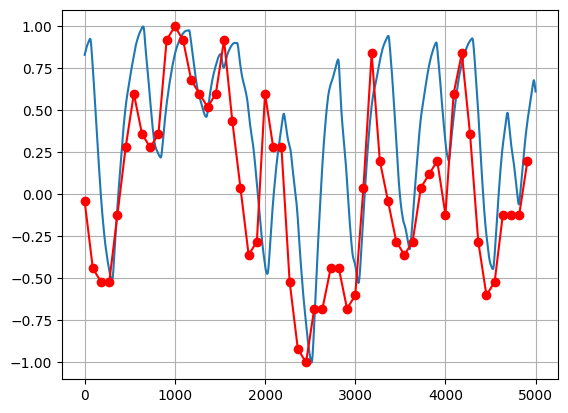

In [24]:
rrss_s_scaled = norm_min_max(rris_s, -1, 1)
resp_n_scaled = norm_min_max(resp_n, -1, 1)

ratio = len(resp_n_scaled) / len(rrss_s_scaled)

t = [x * ratio for x in range(len(rrss_s_scaled))]

plt.plot(resp_n_scaled)
plt.plot(t, rrss_s_scaled, "r-o")
plt.grid()

# wygladzic resp sygnał

### Testing with own ECG / Resp

In [16]:
resp = np.load("E:\\ml-data\\masters-thesis\\myDataset\\Patryk\\ecg_with_resp\\resp.npy").transpose()
ecg = np.load("E:\\ml-data\\masters-thesis\\myDataset\\Patryk\\ecg_with_resp\\ecg.npy").transpose()

print("Time duration for ecg: ", resp[1,-1] - resp[1,0])
print("Time duration for resp: ", ecg[1,-1] -  ecg[1,0])

ratio = 250 / 62.5
print("Sampling frequency ratio: ", ratio)
print("ECG shape: ", ecg.shape)
print("Resp shape: ", ecg.shape)

ecg_last_sample = 10000
resp_last_sample = int(ecg_last_sample/ratio)
print("Last sample for resp: ", resp_last_sample)

# drop timestep channel and normalize the ecg
ecg = ecg[0, :ecg_last_sample]
ecg = norm_min_max(ecg, -1, 1)
resp = resp[0, :resp_last_sample]


print("Resp shape: ", resp.shape)
print("Ecg shape: ", resp.shape)

ecg_input = np.reshape(ecg, (1, len(ecg), 1))
r_peaks = predict(model, ecg_input)
r_peaks = r_peaks.flatten()
rris = peaks_to_rri(r_peaks, sampling_rate=250)

Time duration for ecg:  59794.0
Time duration for resp:  59794.0
Sampling frequency ratio:  4.0
ECG shape:  (2, 14942)
Resp shape:  (2, 14942)
Last sample for resp:  2500
Resp shape:  (2500,)
Ecg shape:  (2500,)


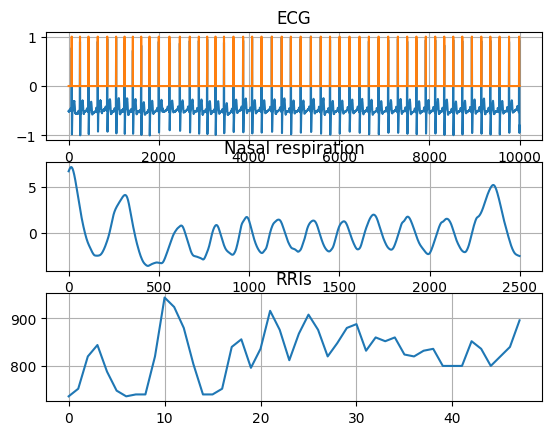

In [17]:
fig, axs = plt.subplots(nrows=3, ncols=1)

ax = axs[0]
ax.plot(ecg)
ax.plot(r_peaks[:10000])
ax.set_title("ECG")
ax.grid()

ax = axs[1]
ax.plot(resp)
ax.set_title("Nasal respiration")
ax.grid()

ax = axs[2]
ax.plot(rris)
ax.set_title("RRIs")
ax.grid()

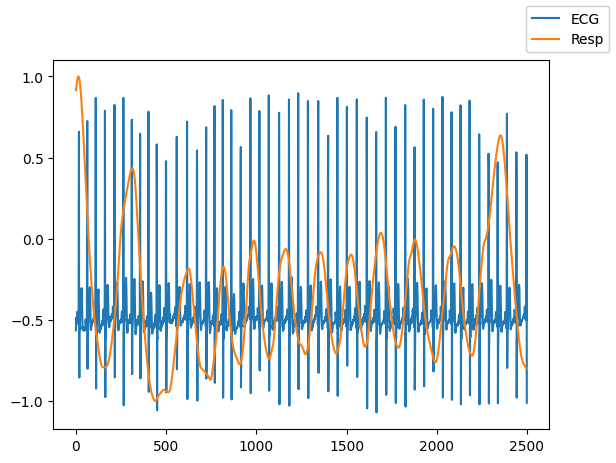

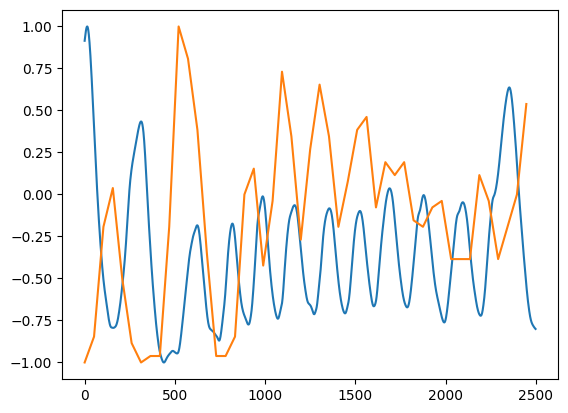

In [18]:
# downsample ECG to match the x-axis
ecg = resample_signal(signal=ecg,num_samples=2500)

# normalize respiratory signal
resp = norm_min_max(resp, -1, 1)

# normalize RRIs signal
rris = norm_min_max(rris, -1, 1)

ratio = len(resp) / len(rris)

t = [x * ratio for x in range(len(rris))]

fig, ax = plt.subplots(ncols=1)
ax.plot(ecg)
ax.plot(resp)
fig.legend(["ECG", "Resp"])

ig, ax = plt.subplots(ncols=1)
ax.plot(resp)
ax.plot(t, rris)
fig.legend(["ECG", "Resp"])